In [ ]:
pip install multiprocess

In [1]:
from underlying import Underlying, NonTradedUnderlying
from option import Option, Vanilla, Vanilla_on_NonTraded
from trader import Trader

import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

from IPython import display
from time import sleep
from multiprocess import Pool

In [2]:
def trader_loop(i, option, V0, sims_t, sims_nt):
    trader = Trader(initial_capital = V0)
    return trader.simulate_hedging(option, [sims_t.iloc[[i],:], sims_nt.iloc[[i],:]], update_freq = 1, mode = 'quantile_nontraded')

In [3]:
mu_nt = 0.06
mu_t = 0.06
sigma_nt =  0.3
sigma_t =  0.3
r = 0.05
X0_nt = 100
X0_t = 100
T = 1
K = 100
repeat = 10000
values_per_year = 250

In [4]:
underlying_t = Underlying(mu_t, sigma_t, r, values_per_year)

In [5]:
rho = 0.9999999999
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [6]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [7]:
call_vanilla = Vanilla(underlying_t, K, T, True)
put_vanilla = Vanilla(underlying_t, K, T, False)

In [8]:
print(call_nt.get_MC_price(X0_t, X0_nt))
print(call_vanilla.get_price(X0_t))

14.293755760935678
14.231254785985819


In [9]:
print(put_nt.get_MC_price(X0_t, X0_nt))
print(put_vanilla.get_price(X0_t))

9.448634794827008
9.354197236057232


In [18]:
rho_call = dict()
for rho in [-0.999, -0.75, -0.25, 0, 0.25, 0.75, 0.999]:
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_call[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, True)

100%|██████████████████████████████████████| 1999/1999 [00:09<00:00, 202.22it/s]


Text(0.5, 1.0, 'Wymagany kapitał początkowy zabezpieczenia opcji call(K = 100) na aktywo niehandlowalne\nw zależności od przyjętego współczynnika m\nw podziale ze wzglęgu na korelację z pomocniczym aktywem handlowalnym')

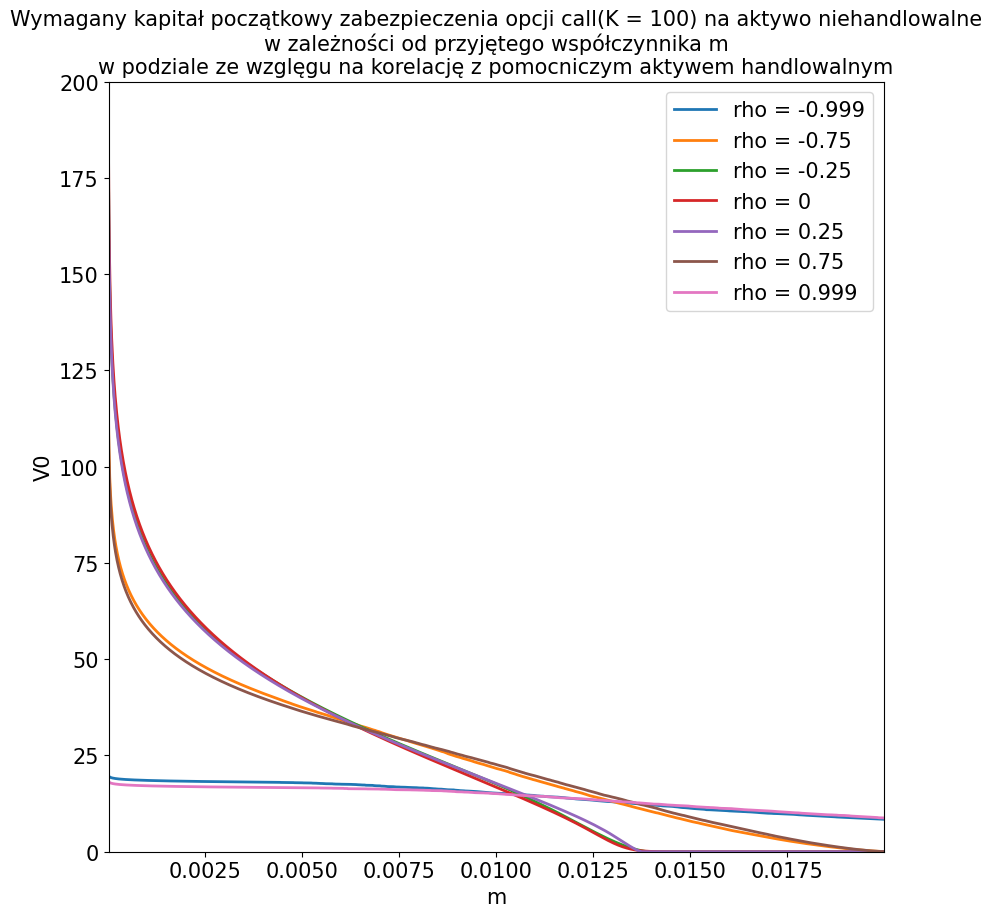

In [19]:
m_s = np.arange(0.00001, 0.02, 0.00001)
plt.figure(figsize=(10,10))
plt.xlabel('m', size = 15)
plt.xlim([np.min(m_s), np.max(m_s)])    
plt.xticks(size = 15)
plt.ylabel('V0', size = 15)
plt.ylim([0, 200])
plt.yticks(size = 15)
for num, rho in enumerate(rho_call):
    prices = []
    for m in tqdm(m_s):
        rho_call[rho].m = m
        V0 = rho_call[rho].get_MC_price(X0_t, X0_nt)
        prices.append(V0)
    plt.plot(m_s, prices, lw = 2, label = f'rho = {rho}')
plt.legend(fontsize = 15)
plt.title(f'Wymagany kapitał początkowy zabezpieczenia opcji call(K = {K}) na aktywo niehandlowalne\nw zależności od przyjętego współczynnika m w podziale\nze wzglęgu na korelację z pomocniczym aktywem handlowalnym',size = 15)


In [20]:
rho_put = dict()
for rho in [-0.999, -0.75, -0.25, 0, 0.25, 0.75, 0.99]:
    underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)
    rho_put[rho] = Vanilla_on_NonTraded(underlying_nt, K, T, False)

100%|██████████████████████████████████████| 1999/1999 [00:09<00:00, 208.87it/s]


Text(0.5, 1.0, 'Wymagany kapitał początkowy zabezpieczenia opcji put(K = 100) na aktywo niehandlowalne\nw zależności od przyjętego współczynnika m\nw podziale ze wzglęgu na korelację z pomocniczym aktywem handlowalnym')

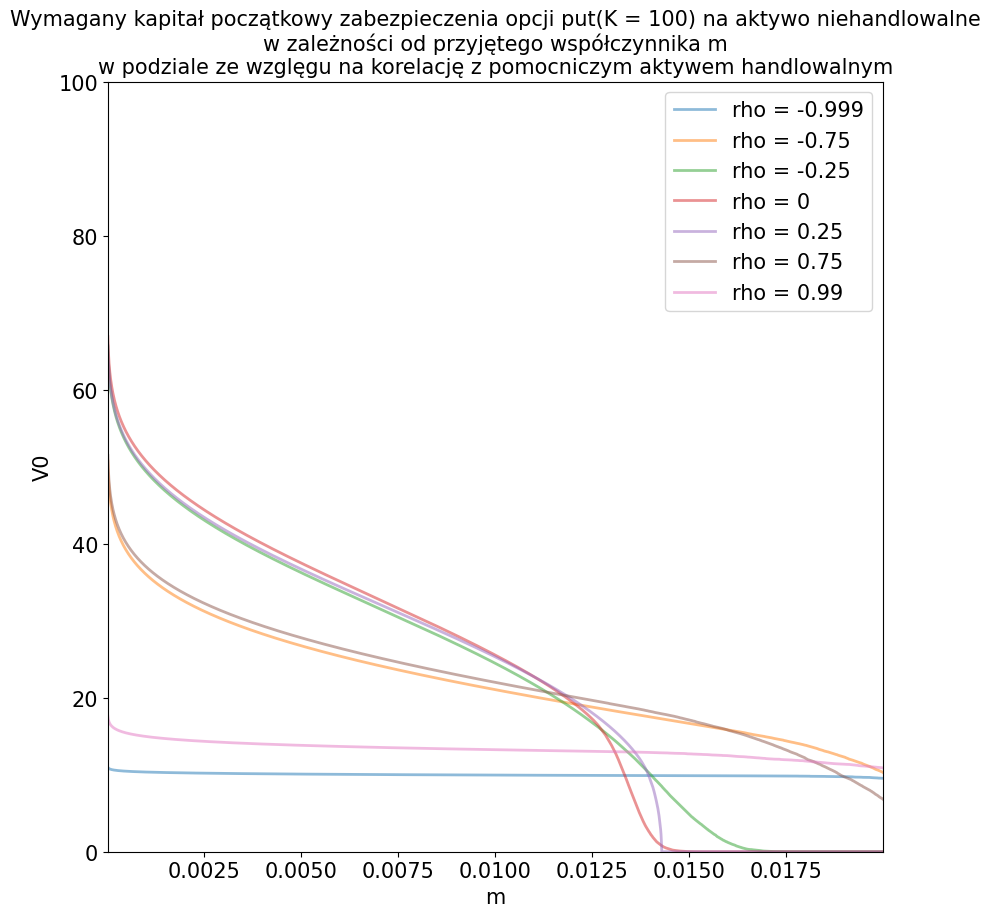

In [21]:
m_s = np.arange(0.00001, 0.02, 0.00001)
plt.figure(figsize=(10,10))
plt.xlabel('m', size = 15)
plt.xlim([np.min(m_s), np.max(m_s)])    
plt.xticks(size = 15)
plt.ylabel('V0', size = 15)
plt.ylim([0, 100])
plt.yticks(size = 15)
for num, rho in enumerate(rho_put):
    prices = []
    for m in tqdm(m_s):
        rho_put[rho].m = m
        V0 = rho_put[rho].get_MC_price(X0_t, X0_nt)
        prices.append(V0)
    plt.plot(m_s, prices, lw = 2, label = f'rho = {rho}', alpha = 0.5)
plt.legend(fontsize = 15)
plt.title(f'Wymagany kapitał początkowy zabezpieczenia opcji put(K = {K}) na aktywo niehandlowalne\nw zależności od przyjętego współczynnika m w podziale\nze wzglęgu na korelację z pomocniczym aktywem handlowalnym',size = 15)


In [ ]:
rho = 0.5
underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)

In [ ]:
[_, reality_t], _ = underlying_nt.simulate_together_P(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
m = 1e-4
diff = 0.0001
rate = 1.5
V0_prev = 5 * [np.infty]
i = 0
while True:
    plt.figure(figsize=(8,8))
    for num, rho in enumerate(rho_call):
        option = rho_call[rho]
        final_index = round(option.underlying.values_per_year * option.T + 1)
        _, sims_full_t = option.MC_setup[0]
        sims_t = sims_full_t.iloc[:repeat,:final_index]
        option.m = m
        payoff = option.payoff_special(X0_t * sims_t, X0_nt)
        V0 = np.exp(-option.underlying.r * option.T) * payoff.mean()
        if abs(V0 - V0_prev[num]) < 0.1:
            i += 1
        V0_prev[num] = V0
        plt.scatter((X0_t * sims_t).iloc[:,-1], payoff, label = f'rho = {rho}, V0 = {V0:.2f}', alpha = 0.1)
    m += diff
    if i == 5:
        i = 0
        diff *= rate
    plt.title(f'Nontradable underlying call modified payoff\nm = {m:.5f}', size = 20)
    plt.xlim([0,300])
    plt.ylim([-5,150])
    plt.legend()
    display.clear_output(wait = True)
    display.display(plt.gcf())
    sleep(0.1)
    if np.max(np.array(V0_prev)) < 1:
        break

In [ ]:
m = 1e-4
diff = 0.0001
rate = 1.5
V0_prev = 5 * [np.infty]
i = 0
while True:
    plt.figure(figsize=(8,8))
    for num, rho in enumerate(rho_put):
        option = rho_put[rho]
        final_index = round(option.underlying.values_per_year * option.T + 1)
        _, sims_full_t = option.MC_setup[0]
        sims_t = sims_full_t.iloc[:repeat,:final_index]
        option.m = m
        payoff = option.payoff_special(X0_t * sims_t, X0_nt)
        V0 = np.exp(-option.underlying.r * option.T) * payoff.mean()
        if abs(V0 - V0_prev[num]) < 0.1:
            i += 1
        V0_prev[num] = V0
        plt.scatter((X0_t * sims_t).iloc[:,-1], payoff, label = f'rho = {rho}, V0 = {V0:.2f}', alpha = 0.1)
    m += diff
    if i == 5:
        i = 0
        diff *= rate
    plt.title(f'Nontradable underlying put modified payoff\nm = {m:.4f}', size = 20)
    plt.xlim([0,300])
    plt.ylim([-5,150])
    plt.legend()
    display.clear_output(wait = True)
    display.display(plt.gcf())
    sleep(0.1)
    if np.max(np.array(V0_prev)) < 1:
        break

In [ ]:
rho = 0.9999999999
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_P(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
V0 = call_nt.get_MC_price(X0_t, X0_nt)

In [ ]:
V0

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
V0 = put_nt.get_MC_price(X0_t, X0_nt)

In [ ]:
V0

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = call_nt.get_MC_price(X0_t, X0_nt)/2

In [ ]:
V0

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = put_nt.get_MC_price(X0_t, X0_nt)/2

In [ ]:
V0

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = 0.75
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = call_nt.get_MC_price(X0_t, X0_nt)

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call1 = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call1 = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call1.loc[num] = item[0]
    delta_time_call1.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
indices = [(X0_t * reality_nt).iloc[:,-1].idxmax(),(X0_t * reality_nt).iloc[:,-1].idxmin(), abs((X0_t * reality_nt).iloc[:,-1] - K).idxmin()]
(X0_nt*reality_nt.iloc[indices,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny niehandlowalnego aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call1.iloc[indices,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call1.iloc[indices,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call1.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call1.copy()
money_time_call_outcome['outcome'] = money_time_call1.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = -0.75
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = 0.25
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
rho = -0.25
underlying_nt = NonTradedUnderlying(mu_t, sigma_t, underlying_t, rho)

In [ ]:
repeat = 1000

In [ ]:
[_, reality_t], [_, reality_nt] = underlying_nt.simulate_together_Q(repeat, T)

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    call_nt.m = m
    price = call_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
call_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_call = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_call = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, call_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_call.loc[num] = item[0]
    delta_time_call.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_call.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_call.iloc[:,-1]) - 5, np.max(money_time_call.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

In [ ]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
V0 = 10

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [ ]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

In [ ]:
V0 = 1

In [ ]:
old_diff = np.infty
step = 0.00001
for m in np.arange(0.00001, 1, step):
    put_nt.m = m
    price = put_nt.get_MC_price(X0_t, X0_nt)
    diff = abs(price - V0)
    if diff > old_diff:
        break
    old_diff = diff
put_nt.m = m - step

In [ ]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special((X0_t * reality_t), X0_nt))

In [ ]:
money_time_put = pd.DataFrame(np.zeros(reality_t.shape))
delta_time_put = pd.DataFrame(np.zeros(reality_t.shape))
with Pool(8) as p:
        results = p.map(lambda i: trader_loop(i, put_nt, V0, (X0_t*reality_t), (X0_nt*reality_nt)) , np.arange(0,repeat))
for num, item in enumerate(results):
    money_time_put.loc[num] = item[0]
    delta_time_put.loc[num] = item[1]   

In [ ]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0_nt*reality_nt.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,values_per_year])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,values_per_year])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,values_per_year])

In [ ]:
plt.figure(figsize = (10,10))
sb.histplot(money_time_put.iloc[:,-1], bins = 50, stat = 'density').set(xlim = [np.min(money_time_put.iloc[:,-1]) - 5, np.max(money_time_put.iloc[:,-1]) + 5], title = f'Dopasowany do V0 hedging kwantylowy\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

In [ ]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.1 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying_nt.values_per_year * T], bins = 20, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')